In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from  scipy.stats import skew, kurtosis, shapiro
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.seasonal import seasonal_decompose

# Time Series Forecasting for UK Energy Consumption
The dataset has daily data for the past 5 years and we want to workcast for the next 12 months. 


To do so, we will be creating monthly data from our daily dataset. There are many ways to do so but we are going to aggregate the daily data for every month so we can have a monthly forecast for the next 12 months.

### Loading the dataset

In [2]:

df = pd.read_csv('energy.dat', parse_dates=['Date'], index_col=['Date'])

# mean aggregation for daily data --> monthly data
data = df.resample('M').mean()

In [3]:
# dividing training data into training and testing 

# training data is first 4 years
training_set = data.iloc[:49]
training_set_value = data.iloc[:49].values

# testing data is last 1 year
dataset_test = data.iloc[48:]
dataset_test_value = data.values

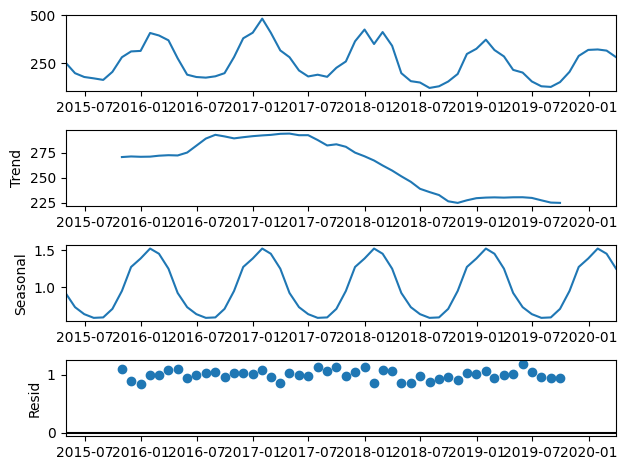

In [4]:
decompose_result_mult = seasonal_decompose(data, model="multiplicative")

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot()
plt.show()

- The __trend__ seems to be almost constant
- There is __seasonality__ in the dataset which is evident.

### Plotting Training and Testing Data

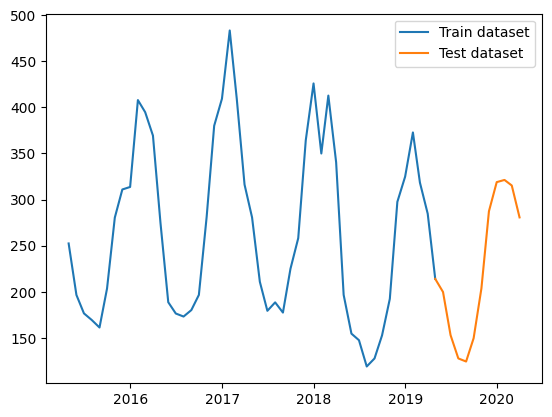

In [5]:

plt.plot(training_set.Consumption, label='Train dataset')
plt.plot(dataset_test.Consumption, label='Test dataset')
plt.legend()

### Statistical Analysis

Let's test data stationarity using __Augmented Dicke-Fuller Method__ .

In [6]:
from statsmodels.tsa.stattools import adfuller

#perform augmented Dickey-Fuller test
_,p,_,_,_,_ = adfuller(data.values)

In [7]:
p

0.8970778157928753

since the p values is < 0.05 . the is __Non-Stationary__

Text(0.5, 1.0, 'Monthly analysis: Distribution over months')

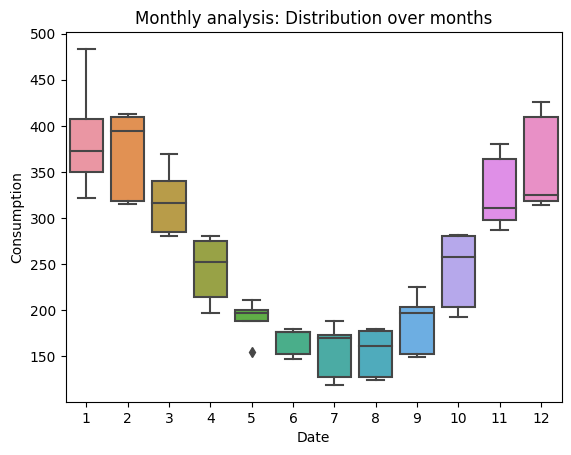

In [8]:
sns.boxplot(data=data, x=data.index.month, y="Consumption")
plt.title("Monthly analysis: Distribution over months")


We can clearly see the Energy consumption is far more in winter (Nov-Feb) than summers (May - Sep).

Text(0.5, 1.0, 'Trend Analysis: Annual Box-plot Distribution')

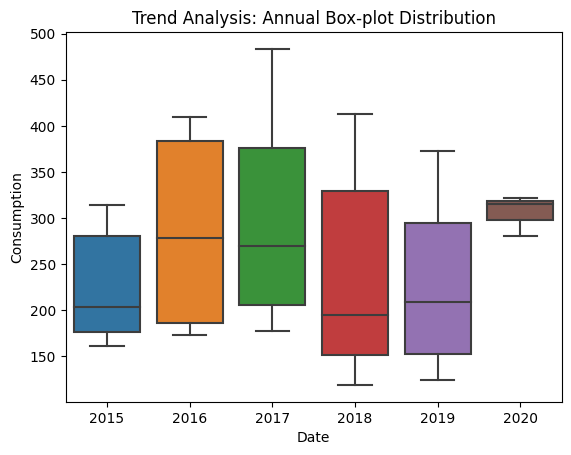

In [9]:
# yearly analysis
sns.boxplot(data=data, x=data.index.year, y="Consumption")
plt.title("Trend Analysis: Annual Box-plot Distribution")


- The yearly analysis reveal that intially from 2015-2017, energy consumption was increasing but then it was controlled in the following years. 
- 2020 seem to have narrow variance probbaly due to covid, everyone was at their home and that is also probably why we see more energy consumption. 

### Model Building 

Since, the data is stationary we will not be using ARIMA. We can use use many different technique's like FB Prophet, Deep Learning probabilistic forecasting. We will be using Deep Learning using LSTM for forecasting becasue the dataset is fairly easy to interpret and forecast.

In [10]:
# NOrmalizing
sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(training_set_value)

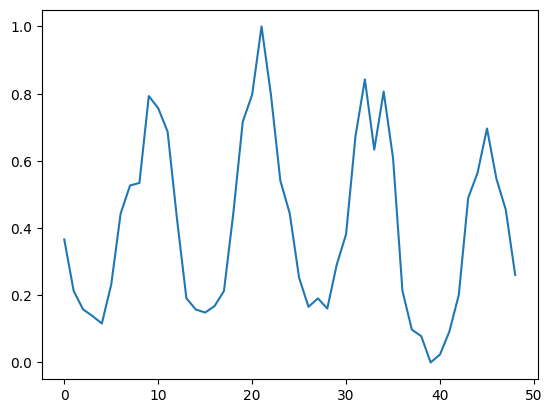

In [11]:
# scaled training data
plt.plot(training_set_scaled)

In [12]:
lag = 14
def prepare_trainingdata(data, lag = lag):
    X_train = []
    y_train = []
    training_set_scaled = sc.transform(data)
    for i in range(lag, len(data)):
        X_train.append(training_set_scaled[i-lag:i, 0])
        y_train.append(training_set_scaled[i, 0])

    X_train, y_train = np.array(X_train), np.array(y_train)


    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    return X_train, y_train

In [13]:
X_train, y_train = prepare_trainingdata(training_set_value )

In [14]:
def lstm_model():
    regressor = Sequential()

    regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    regressor.add(Dropout(0.2))

    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(0.2))

    regressor.add(LSTM(units = 50))
    regressor.add(Dropout(0.2))

    regressor.add(Dense(units = 1))

    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    return regressor


In [15]:

regressor = lstm_model()
callback = EarlyStopping(monitor='loss', patience=20, restore_best_weights = True)
regressor.fit(X_train, y_train, 
    epochs = 100, 
    batch_size = lag, 
    callbacks=[callback]
)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-02-03 21:35:15.002500: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-03 21:35:15.002813: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2023-02-03 21:35:15.404072: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-03 21:35:16.631485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-03 21:35:16.950753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-03 21:35:17.042553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-03 21:35:17.097673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-03 21:35:17.202776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-03 21:35:17.319568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114

3/3 [==============================] - 2s 106ms/step - loss: 0.2117
Epoch 2/100
3/3 [==============================] - 0s 25ms/step - loss: 0.1240
Epoch 3/100
3/3 [==============================] - 0s 25ms/step - loss: 0.0815
Epoch 4/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0968
Epoch 5/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0890
Epoch 6/100
3/3 [==============================] - 0s 24ms/step - loss: 0.0698
Epoch 7/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0826
Epoch 8/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0809
Epoch 9/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0716
Epoch 10/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0721
Epoch 11/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0723
Epoch 12/100
3/3 [==============================] - 0s 25ms/step - loss: 0.0639
Epoch 13/100
3/3 [==============================] - 0s 22ms/

In [16]:
# xgb = XGBRegressor(learning_rate= 0.05, max_depth= 3, n_estimators= 50,
#                   objective = "reg:squarederror",verbosity= 0)
# xgb.fit(X_train,y_train)
# pred = xgb.predict(X_train)


In [17]:
dataset_total = data['Consumption']
tests = dataset_total[len(dataset_total) - len(dataset_test) - lag:].values
tests = tests.reshape(-1,1)
tests = sc.transform(tests)
X_test = []
for i in range(lag, 12+lag):
    X_test.append(tests[i-lag:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_data = regressor.predict(X_test)
# predicted_data = xgb.predict(X_test)
predicted_data = sc.inverse_transform(predicted_data)


2023-02-03 21:35:23.192153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-03 21:35:23.298035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-03 21:35:23.339768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-03 21:35:23.386533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 504ms/step


In [18]:
dataset_test['predicted_data'] = predicted_data

/var/folders/hq/y0qwwt4s0w57kn5nqr9tkkpw0000gn/T/ipykernel_42280/1587948436.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_test['predicted_data'] = predicted_data


#### Model Evaluation

In [19]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(dataset_test['Consumption'], dataset_test.predicted_data)
mse

1760.8242322770593

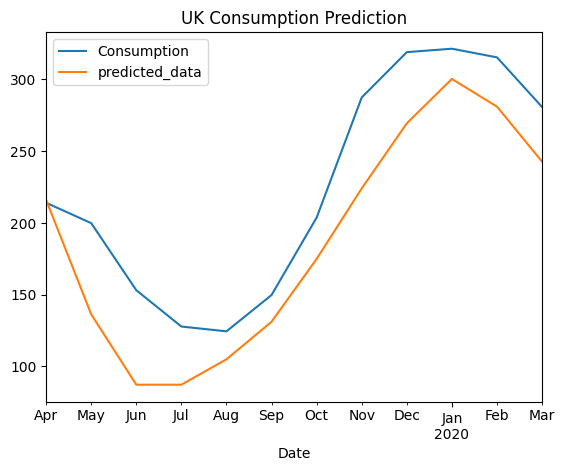

In [20]:
dataset_test.plot(kind='line')
# plt.plot(dataset_test.Consumption, color = 'red', label = 'Real UK Consumption')
# plt.plot(dataset_test.predicted_data, color = 'blue', label = 'Predicted UK Consumption')
plt.title('UK Consumption Prediction')
plt.legend()

The model seems to be working pretty alright. Now we will train it on the entire dataset before we can get forecast on the entire dataset. 

#### model training on entire dataset

In [21]:
X_train,y_train = prepare_trainingdata(data.values)
X_train.shape

(46, 14, 1)

In [22]:
X_train.shape

(46, 14, 1)

In [23]:

model = lstm_model()
model.fit(X_train, y_train, 
    epochs = 100, 
    batch_size = lag, 
    callbacks=[callback]

)

Epoch 1/100


2023-02-03 21:35:27.146458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-03 21:35:27.451845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-03 21:35:27.502580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-03 21:35:27.556167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-03 21:35:27.631097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/4 [======>.......................] - ETA: 5s - loss: 0.1961

2023-02-03 21:35:27.721225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-03 21:35:27.813215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 2s 90ms/step - loss: 0.1812
Epoch 2/100
4/4 [==============================] - 0s 27ms/step - loss: 0.0957
Epoch 3/100
4/4 [==============================] - 0s 27ms/step - loss: 0.0692
Epoch 4/100
4/4 [==============================] - 0s 29ms/step - loss: 0.0666
Epoch 5/100
4/4 [==============================] - 0s 27ms/step - loss: 0.0630
Epoch 6/100
4/4 [==============================] - 0s 24ms/step - loss: 0.0654
Epoch 7/100
4/4 [==============================] - 0s 25ms/step - loss: 0.0659
Epoch 8/100
4/4 [==============================] - 0s 25ms/step - loss: 0.0631
Epoch 9/100
4/4 [==============================] - 0s 26ms/step - loss: 0.0593
Epoch 10/100
4/4 [==============================] - 0s 25ms/step - loss: 0.0547
Epoch 11/100
4/4 [==============================] - 0s 25ms/step - loss: 0.0531
Epoch 12/100
4/4 [==============================] - 0s 24ms/step - loss: 0.0482
Epoch 13/100
4/4 [==============================] - 0s 23ms/s

### Forecasting for upcoming 12 months

In [24]:
prediction_set = data.iloc[-lag:, :].values
prediction_set_scaled = sc.transform(prediction_set)

In [30]:

X_train = prediction_set.reshape(1, len(prediction_set))

n_ahead = 12
y_hat = []
for i in range(0, n_ahead):
    
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    predicted = model.predict(X_train)
    predicted_inverse = sc.inverse_transform(predicted)
    y_hat.append(predicted_inverse)
    prediction_set_scaled = np.append (prediction_set_scaled, predicted)
    prediction_set_scaled = np.delete(prediction_set_scaled, 0)
    X_train = prediction_set_scaled.reshape(1, len(prediction_set_scaled))
    
pred=[]
for i in range(len(y_hat)):
    pred.append(y_hat[i][0][0])

2023-02-03 21:35:51.471365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-03 21:35:51.593322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-03 21:35:51.646755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 20ms/step


2023-02-03 21:35:51.705622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 20ms/step


In [31]:
from dateutil.relativedelta import relativedelta
start_date = '2020-04'
df_ahead = pd.DataFrame({
        'Date': [datetime.strptime(start_date, '%Y-%m') + relativedelta(months=x) for x in range(n_ahead)], 
        'Consumption': pred,
    })

In [32]:
df_ahead

,Date,Consumption
0,2020-04-01,259.820648
1,2020-05-01,122.236176
2,2020-06-01,89.936752
3,2020-07-01,85.202103
4,2020-08-01,90.548599
5,2020-09-01,106.466331
6,2020-10-01,128.217651
7,2020-11-01,153.897827
8,2020-12-01,176.716614
9,2021-01-01,188.945648


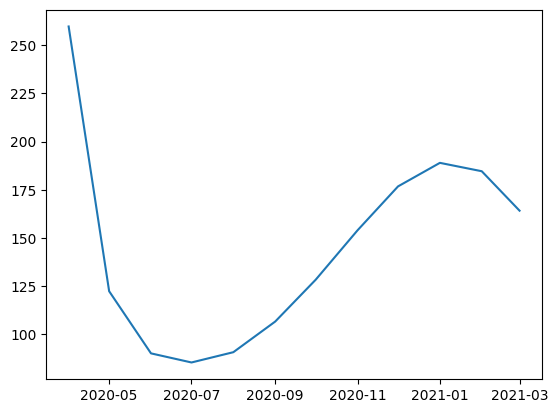

In [33]:
plt.plot(df_ahead['Date'],df_ahead['Consumption'])

(array([16436., 16801., 17167., 17532., 17897., 18262., 18628.]),
 [Text(16436.0, 0, '2015'),
  Text(16801.0, 0, '2016'),
  Text(17167.0, 0, '2017'),
  Text(17532.0, 0, '2018'),
  Text(17897.0, 0, '2019'),
  Text(18262.0, 0, '2020'),
  Text(18628.0, 0, '2021')])

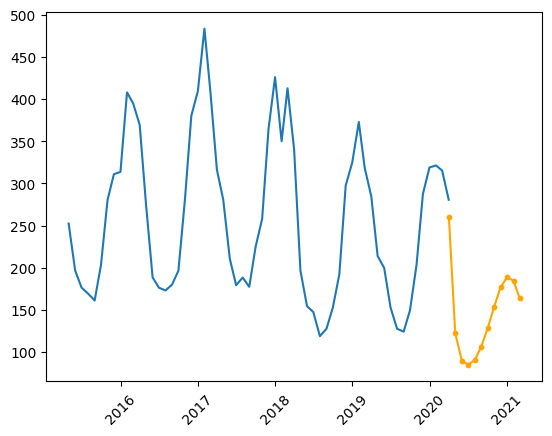

In [34]:
plt.plot(data.index,data['Consumption'])
plt.scatter(df_ahead['Date'],df_ahead['Consumption'], color = 'orange', s = 10)
plt.plot(df_ahead['Date'],df_ahead['Consumption'], color = 'orange')
plt.xticks(rotation=45)